In [61]:
import pandas as pd

In [62]:
true_news=pd.read_csv('True.csv')
fake_news=pd.read_csv('Fake.csv')
true_news['label']=1
fake_news['label']=0

news_data=pd.concat([true_news,fake_news],axis=0)

news_data = news_data.sample(frac=1, random_state=42).reset_index(drop=True)
news_data.head()

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


In [63]:
news_data.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [64]:
news_data.shape

(44898, 5)

In [65]:
X=news_data.drop('label',axis=1)
y=news_data['label']

In [66]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense




In [67]:
vocab_size=5000

messages=X.copy()

messages['title'][1]

' Failed GOP Candidates Remembered In Hilarious Mocking Eulogies (VIDEO)'

In [68]:
messages

,title,text,subject,date
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017"
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016"
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016"
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017"
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017"
...,...,...,...,...
44893,Nigeria says U.S. agrees delayed $593 million ...,ABUJA (Reuters) - The United States has formal...,worldnews,"December 27, 2017"
44894,Boiler Room #62 – Fatal Illusions,Tune in to the Alternate Current Radio Network...,Middle-east,"June 29, 2016"
44895,ATHEISTS SUE GOVERNOR OF TEXAS Over Display on...,I m convinced the Freedom From Religion group...,Government News,"Feb 27, 2016"
44896,Republican tax plan would deal financial hit t...,WASHINGTON (Reuters) - The Republican tax plan...,politicsNews,"November 2, 2017"


In [69]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [70]:


ps = PorterStemmer()
stop_words = set(stopwords.words("english"))

corpus = []

for title in messages['title']:
    review = re.sub("[^a-zA-Z]", " ", title)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if word not in stop_words]
    review = " ".join(review)
    corpus.append(review)


In [71]:
corpus

['break gop chairman grassley enough demand trump jr testimoni',
 'fail gop candid rememb hilari mock eulog video',
 'mike penc new dc neighbor hilari troll homophob bigot',
 'california ag pledg defend birth control insur coverag',
 'az rancher live us mexico border destroy nanci pelosi claim trump weak want border wall video',
 'privat lawyer trump high court pick friend busi',
 'yemeni salafist imam kill aden sourc',
 'fbi say wit u probe malaysia mdb fear safeti',
 'easi read chart show berni sander social step stone commun',
 'mma fighter jake shield embarrass coward mask violent beat trump support video berkeley watch man get beat mob polic help person jump help',
 'tire thing go well marco rubio make promis destroy america video',
 'yemen air strike kill eight women two children say resid',
 'break wdbj killer angri black democrat reprimand wear obama sticker work',
 'list time obama call phoni climat chang seriou terror',
 'indo pacif china sit',
 'art contest winner disqualifi

One-Hot the corpus

In [72]:

from tensorflow.keras.preprocessing.text import one_hot

onehot_repr=[one_hot(words,vocab_size)for words in corpus]
print(onehot_repr[2])

[4604, 814, 3547, 4409, 4786, 2544, 3100, 860, 4018]


Pre-padding the one-hot to make the length same

In [73]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2471 3306 4029]
 [   0    0    0 ...    5 3820 4228]
 [   0    0    0 ... 3100  860 4018]
 ...
 [   0    0    0 ... 1235 2286 1385]
 [   0    0    0 ... 3042 1564 2599]
 [   0    0    0 ... 1170 2413 4257]]


In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

embedding_vector_features=50
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.build(input_shape=(None, sent_length))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 20, 50)         │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,501 (1.18 MB)

 Trainable params: 310,501 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

None


In [75]:
import numpy as np
x_final=np.array(embedded_docs)
y_final=np.array(y)


In [76]:
X_train,X_test,y_train,y_test=train_test_split(x_final,y_final,test_size=0.33,random_state=42)


Training the model

In [77]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8311 - loss: 0.3408 - val_accuracy: 0.9409 - val_loss: 0.1504
Epoch 2/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.9559 - loss: 0.1124 - val_accuracy: 0.9370 - val_loss: 0.1763
Epoch 3/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9707 - loss: 0.0814 - val_accuracy: 0.9438 - val_loss: 0.1498
Epoch 4/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.9769 - loss: 0.0613 - val_accuracy: 0.9424 - val_loss: 0.1640
Epoch 5/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9829 - loss: 0.0469 - val_accuracy: 0.9432 - val_loss: 0.1855
Epoch 6/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.9886 - loss: 0.0343 - val_accuracy: 0.9416 - val_loss: 0.2235
Epoch 7/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9913 - loss: 0.0253 - val_accuracy: 0.9289 - val_loss: 0.2385
Epoch 8/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9932 - loss: 0.0230 - 

In [81]:
y_pred=model.predict(X_test)
y_pred=np.where(y_pred>0.5,1,0).ravel()

464/464 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [83]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7738
           1       0.94      0.93      0.94      7079

    accuracy                           0.94     14817
   macro avg       0.94      0.94      0.94     14817
weighted avg       0.94      0.94      0.94     14817



464/464 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


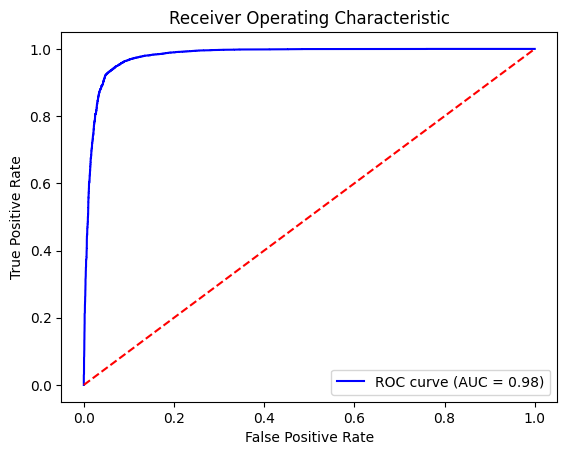

In [84]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_pred_prob = model.predict(X_test).ravel()


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # random line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Adding Dropout

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout

embedding_vector_features=50
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100,recurrent_dropout=0.2))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.build(input_shape=(None, sent_length))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 20, 50)         │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,501 (1.18 MB)

 Trainable params: 310,501 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

None


In [90]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.8436 - loss: 0.3456 - val_accuracy: 0.9336 - val_loss: 0.1634
Epoch 2/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.9508 - loss: 0.1287 - val_accuracy: 0.9372 - val_loss: 0.1647
Epoch 3/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9639 - loss: 0.1012 - val_accuracy: 0.9411 - val_loss: 0.1459
Epoch 4/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.9714 - loss: 0.0769 - val_accuracy: 0.9405 - val_loss: 0.1612
Epoch 5/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.9777 - loss: 0.0595 - val_accuracy: 0.9406 - val_loss: 0.1690
Epoch 6/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9830 - loss: 0.0482 - val_accuracy: 0.9389 - val_loss: 0.1953
Epoch 7/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9879 - loss: 0.0334 - val_accuracy: 0.9402 - val_loss: 0.2316
Epoch 8/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.9906 - loss: 0.0262 - 